In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os, random, shutil
import PIL
from pathlib import Path
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("drive/MyDrive/Colab_Notebooks/data.rar", outdir="drive/MyDrive/Colab_Notebooks/")

INFO patool: Extracting drive/MyDrive/Colab_Notebooks/data.rar ...
INFO:patool:Extracting drive/MyDrive/Colab_Notebooks/data.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/Colab_Notebooks/data.rar
INFO:patool:running /usr/bin/unrar x -kb -or -- /content/drive/MyDrive/Colab_Notebooks/data.rar
INFO patool: ... drive/MyDrive/Colab_Notebooks/data.rar extracted to `drive/MyDrive/Colab_Notebooks/'.
INFO:patool:... drive/MyDrive/Colab_Notebooks/data.rar extracted to `drive/MyDrive/Colab_Notebooks/'.


'drive/MyDrive/Colab_Notebooks/'

## Переименование файлов

In [ ]:
def func_rename_photos(data_folder):
    for folder in os.listdir(data_folder):
        for i, photo in enumerate(os.listdir(data_folder + '//' + folder)):
            os.rename(f'{data_folder}//{folder}//{photo}', f'{data_folder}//{folder}//photo_{i}.jpg')

In [ ]:
func_rename_photos('drive/MyDrive/Colab_Notebooks/data')

## Разделение датасета

In [ ]:
# Функция для разделения на тренировочную и валидационную выборки
def split_data(source_root, target_root):
    '''
    source_root - где находится датасет
    target_root - в какой папке хранить разделенный датасет
    '''
    source_root = Path(source_root)
    target_root = Path(target_root)
    train_size = 0.7
    val_size = 0.15

    for class_name in os.listdir(source_root):
        files = os.listdir(source_root / class_name)
        random.shuffle(files)

        n_total = len(files)
        n_train = int(n_total * train_size)
        n_val = int(n_total * val_size)
        n_test = n_total - n_train - n_val

        splits = {
            'train': files[:n_train],
            'val': files[n_train:n_train+n_val],
            'test': files[n_train+n_val:]
        }

        for subset, subset_files in splits.items():
            dct = target_root / subset / class_name
            dct.mkdir(parents=True, exist_ok=True)
            for f in subset_files:
                shutil.copy(source_root / class_name / f, dct / f)

In [ ]:
split_data('data', 'data_split')

In [3]:
# Функция для подсчета файлов
def total_files(dct):
    total = 0

    for root, dir, file in os.walk(dct):
        total += len(file)

    return total

In [4]:
print(f'Кол-во файлов в train: {total_files("drive/MyDrive/Colab_Notebooks/data_split/train")}')
print(f'Кол-во файлов в val: {total_files("drive/MyDrive/Colab_Notebooks/data_split/val")}')
print(f'Кол-во файлов в test: {total_files("drive/MyDrive/Colab_Notebooks/data_split/test")}')

Кол-во файлов в train: 477
Кол-во файлов в val: 101
Кол-во файлов в test: 107


In [ ]:
# Дублирование изображение (oversampling)
# def duplicate_files(src_dir, dst_dir, class_name, factor):
#     src = os.path.join(src_dir, class_name)
#     dst = os.path.join(dst_dir, class_name)
#     os.makedirs(dst, exist_ok=True)

#     files = [f for f in os.listdir(src) if f.lower().endswith(('.jpg','.png'))]
#     for f in files:
#         shutil.copy(os.path.join(src, f), os.path.join(dst, f))

#     target_count = len(files) * factor
#     while len(os.listdir(dst)) < target_count:
#         f = random.choice(files)
#         new_name = f"{len(os.listdir(dst))}_{f}"
#         shutil.copy(os.path.join(src, f), os.path.join(dst, new_name))

In [ ]:
# for df in ['train', 'val']:
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'good', factor=1)
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'bad', factor=2)
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'great', factor=2)
#     duplicate_files(f'data_split/{df}', f'data_split_oversampled/{df}', 'not_bad', factor=2)

In [ ]:
# print(f'Кол-во файлов в train: {total_files("data_split_oversampled/train")}')
# print(f'Кол-во файлов в val: {total_files("data_split_oversampled/val")}')

Кол-во файлов в train: 514
Кол-во файлов в val: 134


## Предобработка данных

In [5]:
# функция применения clahe для улучшения контрастности и удаление теней
def apply_clahe_pil(img):
    img = (img * 255).astype('uint8') if img.max() <= 1.0 else img.astype('uint8') #
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5., tileGridSize=(32,32))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb.astype('float32')

# def preprocess_with_clahe(x):
#     x_uint8 = (x.astype(np.float32))
#     if x_uint8.max() <= 1.0:
#         x_uint8 = (x_uint8 * 255).astype('uint8')
#     else:
#         x_uint8 = x_uint8.astype('uint8')
#     rgb = apply_clahe_pil(x_uint8)
#     return tf.keras.applications.mobilenet_v3.preprocess_input(rgb)

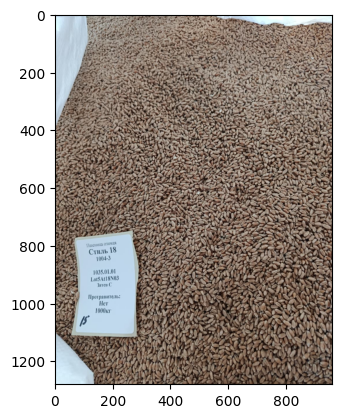

In [ ]:
photo_before_clahe = cv2.imread('drive/MyDrive/Colab_Notebooks/data_split/train/good/photo_100.jpg')
photo_before_clahe = cv2.cvtColor(photo_before_clahe, cv2.COLOR_BGR2RGB)

plt.imshow(photo_before_clahe)
plt.show()

L-channel mean before: 116.75118625217014
L-channel mean after : 128.88203


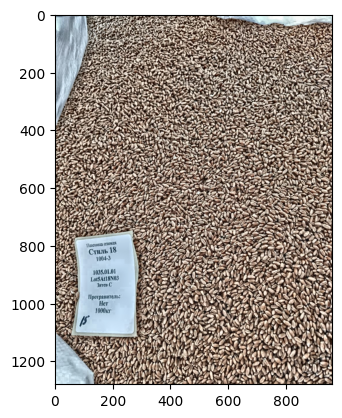

In [ ]:
photo_after_clahe = apply_clahe_pil(photo_before_clahe.astype('uint8'))

print("L-channel mean before:", photo_before_clahe.mean())
print("L-channel mean after :", photo_after_clahe.mean())

plt.imshow(photo_after_clahe.astype('uint8'))
plt.show()

In [6]:
# функция, которая создает маску и возвращает ее, она убирает ненужный фон и лишние объекты
def create_seed_mask(img, lower_seed=np.array([0,0,0]), upper_seed=np.array([180,250,250])):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv, lower_seed, upper_seed)

    mask = cv2.medianBlur(mask, 5)

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask

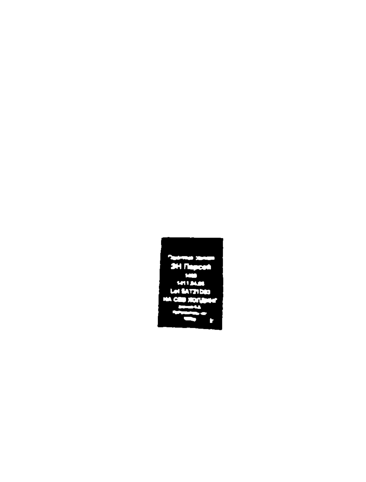

In [ ]:
img_path = "drive/MyDrive/Colab_Notebooks/data_split/train/good/photo_118.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = create_seed_mask(img)

plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# старая функция предобработки данных, обрабатывает изображение целиком и возвращает генератор

# def preprocess_seed_image(img, target_size=(224,224)):
#     mask = create_seed_mask(img)
#     mask_uint8 = (mask > 0).astype(np.uint8) * 255

#     img_masked = cv2.bitwise_and(img, img, mask=mask_uint8)


#     img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])

#     img_clahe = apply_clahe_pil(img_gray_rgb)

#     img_resized = cv2.resize(img_clahe, target_size)
#     img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_resized)

#     return img_preprocessed

In [ ]:
# img_path = "data_split/train/good/photo_1.jpg"
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# img_preprocessed = preprocess_seed_image(img)

# img_display = ((img_preprocessed - img_preprocessed.min()) /
#                (img_preprocessed.max() - img_preprocessed.min()) * 255).astype(np.uint8)

# plt.imshow(img_display, cmap='gray')
# plt.axis('off')
# plt.show()

In [7]:
!pip install patchify

In [8]:
from patchify import patchify

# разделяет изображение на патчи
def extract_patches(img, patch_size=(224,224), step=None, max_patches=None):
    h, w, _ = img.shape
    ph, pw = patch_size

    positions = [(i, j) for i in range(0, h - ph + 1, ph)
                          for j in range(0, w - pw + 1, pw)]

    if len(positions) == 0:
        patch = cv2.resize(img, patch_size)
        return [patch]

    selected_positions = random.sample(positions, min(max_patches, len(positions)))

    patches = [img[i:i+ph, j:j+pw, :] for i,j in selected_positions]

    return patches


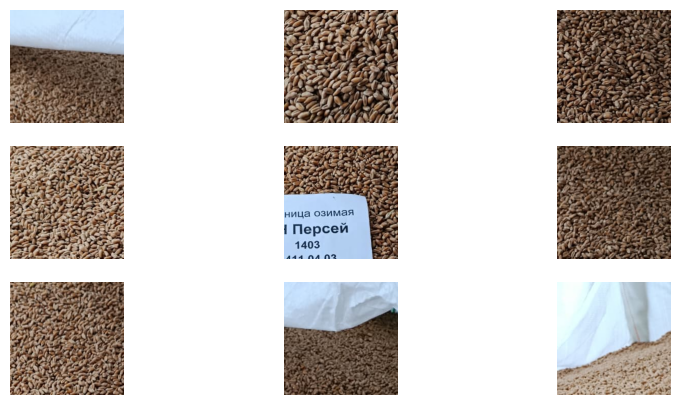

In [ ]:
img_path = "drive/MyDrive/Colab_Notebooks/data_split/train/good/photo_112.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

patches = extract_patches(img, patch_size=(224,224), max_patches=9)

plt.figure(figsize=(10,5))
for i, p in enumerate(patches[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(p)
    plt.axis("off")
plt.show()

In [9]:
# Функция которая фильтрует патчи и доминирующие по цвету патчи оставляет, а меньшинство обнуляет
def filter_noise_patches(patches, n_clusters=2):
    if len(patches) == 0:
        return patches

    avg_colors = np.array([p.reshape(-1, 3).mean(axis=0) for p in patches])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(avg_colors)

    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    dominant_label = labels[np.argmax(counts)]

    filtered_patches = []
    zeroed = 0

    for i, p in enumerate(patches):
        if kmeans.labels_[i] != dominant_label:
            filtered_patches.append(np.zeros_like(p, dtype=np.float32))
            zeroed += 1
        else:
            filtered_patches.append(p)

    return filtered_patches


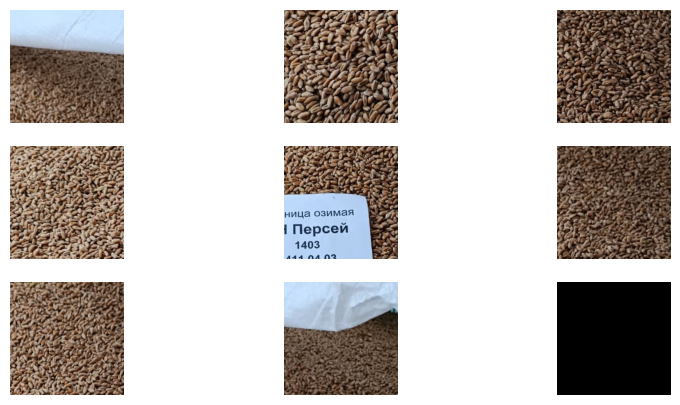

In [ ]:
significant_patches = filter_noise_patches(patches, n_clusters=2)

plt.figure(figsize=(10,5))
for i, p in enumerate(significant_patches):
    plt.subplot(3,3,i+1)
    plt.imshow(p)
    plt.axis("off")
plt.show()

In [ ]:
# берет первый патч у изображения, обрабатывает его и возвращает генератор
# def preprocess_patch_image(img, target_size=(224,224)):
#     patches = extract_patches(img, patch_size=target_size, max_patches=1)
#     patch = patches[0]

#     mask = create_seed_mask(patch)
#     mask_uint8 = (mask > 0).astype(np.uint8) * 255
#     img_masked = cv2.bitwise_and(patch, patch, mask=mask_uint8)

#     img_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
#     img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])
#     img_clahe = apply_clahe_pil(img_gray_rgb)

#     img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_clahe)
#     return img_preprocessed

In [10]:
# создаем список классов и записываем их в порядке возрастания, это пригодится для функции потерь
ordered_classes = ['bad', 'not_bad', 'good', 'great']

In [18]:
def preprocessing_data(train_dir, val_dir, test_dir, target_size=(1024, 1024), batch_size=16):
    train_datagen = ImageDataGenerator(
        preprocessing_function=lambda img: img,
        rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.2,
        brightness_range=(0.6, 1.2),
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=lambda img: img
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=lambda img: img
    )

    train_gen = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        classes=ordered_classes
    )

    val_gen = val_datagen.flow_from_directory(
        directory=val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=ordered_classes
    )

    test_gen = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=ordered_classes
    )

    return train_gen, val_gen, test_gen

In [19]:
train_gen, val_gen, test_gen = preprocessing_data('drive/MyDrive/Colab_Notebooks/data_split/train',
                                        'drive/MyDrive/Colab_Notebooks/data_split/val',
                                        'drive/MyDrive/Colab_Notebooks/data_split/test',
                                        target_size=(1024, 1024),
                                        batch_size=8)

Found 477 images belonging to 4 classes.
Found 101 images belonging to 4 classes.
Found 107 images belonging to 4 classes.


In [20]:
# создаем веса классов, нужжно для борьбы с дисбалансом
labels = train_gen.labels
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
)

class_weights_dict = dict(enumerate(class_weights))
print('Class weights:', class_weights_dict)

Class weights: {0: np.float64(1.125), 1: np.float64(0.8517857142857143), 2: np.float64(0.6411290322580645), 3: np.float64(2.65)}


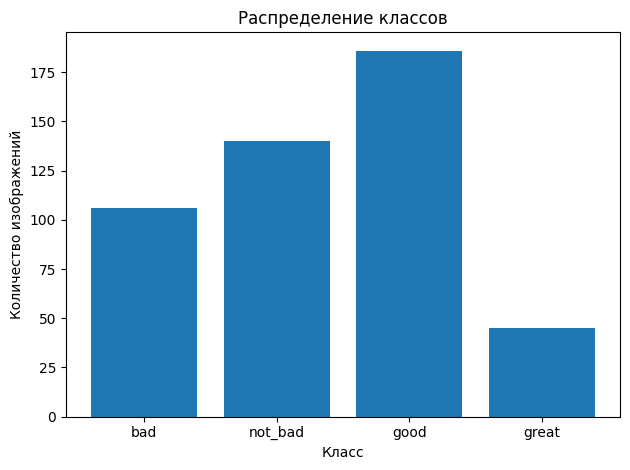

In [21]:
labels = train_gen.classes
class_names = list(train_gen.class_indices.keys())

plt.hist(labels, bins=np.arange(len(class_names)+1)-0.5, rwidth=0.8)
plt.xticks(np.arange(len(class_names)), labels=class_names)
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.title("Распределение классов")
plt.tight_layout()
plt.show()

## Обучение

In [11]:
# функция потерь, учитывает насколько далеко модель предсказала класс, используется в обучении

@keras.saving.register_keras_serializable(package="Custom", name="ordinal_focal_loss")
def ordinal_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25, k=0.5):
    y_pred = tf.clip_by_value(y_pred,
                              tf.keras.backend.epsilon(),
                              1. - tf.keras.backend.epsilon())

    cross_entropy = -y_true * tf.math.log(y_pred)
    focal_weight = alpha * tf.pow(1 - y_pred, gamma)

    true_idx = tf.cast(tf.argmax(y_true, axis=1), tf.float32)
    pred_idx = tf.cast(tf.range(tf.shape(y_pred)[1]), tf.float32)

    dist_matrix = tf.abs(
        tf.expand_dims(true_idx, axis=1) - tf.expand_dims(pred_idx, axis=0)
    )

    weight = focal_weight * (1.0 + k * dist_matrix)

    loss = weight * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

## Модель с MIL агрегацией

In [23]:
# функция, которая обрабатывает мешок патчей

def preprocess_patch_bag(img, target_size=(224,224), max_patches=None):
    patches = extract_patches(img, patch_size=target_size, max_patches=max_patches)
    patches = filter_noise_patches(patches, n_clusters=2)
    bag = []
    for patch in patches:
        mask = create_seed_mask(patch)
        mask_uint8 = (mask > 0).astype(np.uint8) * 255
        img_masked = cv2.bitwise_and(patch, patch, mask=mask_uint8)

        img_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)
        img_gray_rgb = cv2.merge([img_gray, img_gray, img_gray])
        img_clahe = apply_clahe_pil(img_gray_rgb)

        img_preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(img_clahe)
        bag.append(img_preprocessed)

    return np.array(bag)

In [24]:
# функция, которая создает генератор для модель используя функцию предобработки мешка патчей
def mil_generator(generator, target_size=(224,224), max_patches=None):
    while True:
        batch_x, batch_y = next(generator)
        bags = []
        for img in batch_x:
            bag = preprocess_patch_bag(img, target_size=target_size, max_patches=max_patches)
            bags.append(bag)
        max_len = max(len(b) for b in bags)
        bags_padded = np.zeros((len(bags), max_len, target_size[0], target_size[1], 3), dtype=np.float32)
        for i, b in enumerate(bags):
            bags_padded[i, :len(b)] = b
        yield bags_padded, batch_y


In [25]:
train_mil_gen = mil_generator(train_gen, target_size=(224, 224), max_patches=10)
val_mil_gen   = mil_generator(val_gen, target_size=(224, 224), max_patches=10)

In [26]:
# функция которая создает генератор с весами, так как такие требования у tensorflow последней версс
def add_sample_weights(generator, class_weights):
    for x, y in generator:
        if y.ndim > 1 and y.shape[-1] > 1:
            class_indices = np.argmax(y, axis=-1)
        else:
            class_indices = y

        weights = np.array([class_weights[c] for c in class_indices])

        yield x, y, weights

In [27]:
train_mil_gen_w = add_sample_weights(train_mil_gen, class_weights)
val_mil_gen_w = add_sample_weights(val_mil_gen, class_weights)

## Создание и компиляция модели

In [12]:
input_shape = (224, 224, 3)

# базовая модель на основе mobilenev3large
base_model = applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

In [13]:
num_classes = len(ordered_classes)

patch_input = keras.Input(shape=(224,224,3))
patch_features = base_model(patch_input, training=False)
patch_features = GlobalAveragePooling2D()(patch_features)
patch_encoder = keras.Model(patch_input, patch_features)

bag_input = keras.Input(shape=(None, 224,224,3))

encoded_patches = keras.layers.TimeDistributed(patch_encoder)(bag_input)

att_logits = Dense(1, activation='tanh',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-4))(encoded_patches)
att_weights = tf.keras.layers.Softmax(axis=1, name='att_softmax')(att_logits)
weighted = keras.layers.Multiply()([att_weights, encoded_patches])

@keras.saving.register_keras_serializable(package="Custom")
def att_pool_func(z):
    return tf.reduce_sum(z, axis=1)

@keras.saving.register_keras_serializable(package="Custom")
def att_pool_shape(input_shape):
    return (input_shape[0], input_shape[2])
bag_representation = keras.layers.Lambda(
    att_pool_func,
    output_shape=att_pool_shape,
    name='att_pool'

)(weighted)
x = Dense(1024, activation='relu')(bag_representation)
x = keras.layers.Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = keras.Model(bag_input, output)

model.compile(
    optimizer=Adam(1e-4),
    loss=ordinal_focal_loss,
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, None, 224, │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, None, 960) │  2,996,352 │ input_layer_30[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, None, 1)   │        961 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_softmax         │ (None, None, 1)   │          0 │ dense_45[0][0]    │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_35         │ (None, None, 960) │          0 │ att_softmax[0][0… │
│ (Multiply)          │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_pool (Lambda)   │ (None, 960)       │          0 │ multiply_35[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 1024)      │    984,064 │ att_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1024)      │          0 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 4)         │      4,100 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,985,477 (15.20 MB)

 Trainable params: 3,961,077 (15.11 MB)

 Non-trainable params: 24,400 (95.31 KB)

## Обучение модели

In [31]:
checkpoint_keras = tf.keras.callbacks.ModelCheckpoint(
    'drive/MyDrive/Colab_Notebooks/best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

checkpoint_h5 = tf.keras.callbacks.ModelCheckpoint(
    'drive/MyDrive/Colab_Notebooks/best_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

csv_logger = tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab_Notebooks/training_log.csv', append=True)

callbacks = [checkpoint_keras, checkpoint_h5, early_stop, reduce_lr, csv_logger]

In [ ]:
# запускать только при обучении на GPU

# from tensorflow.keras import mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
model.fit(
    train_mil_gen_w,
    validation_data=val_mil_gen_w,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4717 - loss: 0.1601 
Epoch 1: val_loss improved from inf to 0.13240, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoch 1: val_loss improved from inf to 0.13240, saving model to drive/MyDrive/Colab_Notebooks/best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 1202s 17s/step - accuracy: 0.4730 - loss: 0.1596 - val_accuracy: 0.5446 - val_loss: 0.1324 - learning_rate: 1.0000e-04
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6663 - loss: 0.0874 
Epoch 2: val_loss improved from 0.13240 to 0.12522, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoch 2: val_loss improved from 0.13240 to 0.12522, saving model to drive/MyDrive/Colab_Notebooks/best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 964s 16s/step - accuracy: 0.6661 - loss: 0.0875 - val_accuracy: 0.4455 - val_loss: 0.1252 - learning_rate: 1.0000e-04
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6817 - loss: 0.0788 
Epoch 3: val_loss improved from 0.12522 to 0.08519, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoch 3: val_loss improved from 0.12522 to 0.08519, saving model to drive/MyDrive/Colab_Notebooks/best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 958s 16s/step - accuracy: 0.6818 - loss: 0.0788 - val_accuracy: 0.6535 - val_loss: 0.0852 - learning_rate: 1.0000e-04
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7610 - loss: 0.0636 
Epoch 4: val_loss did not improve from 0.08519

Epoch 4: val_loss did not improve from 0.08519
60/60 ━━━━━━━━━━━━━━━━━━━━ 950s 16s/step - accuracy: 0.7607 - loss: 0.0637 - val_accuracy: 0.7030 - val_loss: 0.0891 - learning_rate: 1.0000e-04
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7490 - loss: 0.0521 
Epoch 5: val_loss did not improve from 0.08519

Epoch 5: val_loss did not improve from 0.08519
60/60 ━━━━━━━━━━━━━━━━━━━━ 980s 16s/step - accuracy: 0.7488 - loss: 0.0522 - val_accuracy: 0.6040 - val_loss: 0.0893 - learning_rate: 1.0000e-04
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7171 - loss: 0.0669 
Epoch 6: val_loss improved from 0.08519 to 0.06664, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoc

60/60 ━━━━━━━━━━━━━━━━━━━━ 990s 17s/step - accuracy: 0.7170 - loss: 0.0669 - val_accuracy: 0.7822 - val_loss: 0.0666 - learning_rate: 1.0000e-04
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7683 - loss: 0.0497 
Epoch 7: val_loss improved from 0.06664 to 0.05244, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoch 7: val_loss improved from 0.06664 to 0.05244, saving model to drive/MyDrive/Colab_Notebooks/best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 980s 16s/step - accuracy: 0.7679 - loss: 0.0498 - val_accuracy: 0.8416 - val_loss: 0.0524 - learning_rate: 1.0000e-04
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8020 - loss: 0.0445 
Epoch 8: val_loss improved from 0.05244 to 0.05155, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoch 8: val_loss improved from 0.05244 to 0.05155, saving model to drive/MyDrive/Colab_Notebooks/best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 962s 16s/step - accuracy: 0.8018 - loss: 0.0446 - val_accuracy: 0.7822 - val_loss: 0.0515 - learning_rate: 1.0000e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7838 - loss: 0.0446 
Epoch 9: val_loss did not improve from 0.05155

Epoch 9: val_loss did not improve from 0.05155
60/60 ━━━━━━━━━━━━━━━━━━━━ 977s 16s/step - accuracy: 0.7839 - loss: 0.0446 - val_accuracy: 0.6832 - val_loss: 0.0843 - learning_rate: 1.0000e-04
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7854 - loss: 0.0405 
Epoch 10: val_loss improved from 0.05155 to 0.03189, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoch 10: val_loss improved from 0.05155 to 0.03189, saving model to drive/MyDrive/Colab_Notebooks/best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 985s 16s/step - accuracy: 0.7853 - loss: 0.0405 - val_accuracy: 0.8020 - val_loss: 0.0319 - learning_rate: 1.0000e-04
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7628 - loss: 0.0452 
Epoch 11: val_loss did not improve from 0.03189

Epoch 11: val_loss did not improve from 0.03189
60/60 ━━━━━━━━━━━━━━━━━━━━ 919s 15s/step - accuracy: 0.7632 - loss: 0.0452 - val_accuracy: 0.6832 - val_loss: 0.0377 - learning_rate: 1.0000e-04
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7474 - loss: 0.0485 
Epoch 12: val_loss did not improve from 0.03189

Epoch 12: val_loss did not improve from 0.03189
60/60 ━━━━━━━━━━━━━━━━━━━━ 979s 16s/step - accuracy: 0.7477 - loss: 0.0485 - val_accuracy: 0.7426 - val_loss: 0.0426 - learning_rate: 1.0000e-04
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8150 - loss: 0.0450 
Epoch 13: val_loss did not improve from 0.03189

Epoch 13: val_loss did not improve from 0.03189
60/60 ━━━━━━━━━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 868s 14s/step - accuracy: 0.8495 - loss: 0.0301 - val_accuracy: 0.7723 - val_loss: 0.0301 - learning_rate: 5.0000e-05
Epoch 18/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8112 - loss: 0.0320 
Epoch 18: val_loss improved from 0.03015 to 0.02985, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoch 18: val_loss improved from 0.03015 to 0.02985, saving model to drive/MyDrive/Colab_Notebooks/best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 820s 14s/step - accuracy: 0.8111 - loss: 0.0320 - val_accuracy: 0.7921 - val_loss: 0.0298 - learning_rate: 5.0000e-05
Epoch 19/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7846 - loss: 0.0386 
Epoch 19: val_loss did not improve from 0.02985

Epoch 19: val_loss did not improve from 0.02985
60/60 ━━━━━━━━━━━━━━━━━━━━ 858s 14s/step - accuracy: 0.7852 - loss: 0.0385 - val_accuracy: 0.7822 - val_loss: 0.0308 - learning_rate: 5.0000e-05
Epoch 20/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8120 - loss: 0.0323 
Epoch 20: val_loss did not improve from 0.02985

Epoch 20: val_loss did not improve from 0.02985
60/60 ━━━━━━━━━━━━━━━━━━━━ 802s 13s/step - accuracy: 0.8118 - loss: 0.0323 - val_accuracy: 0.6931 - val_loss: 0.0446 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 18.


In [32]:
best_model = keras.models.load_model("drive/MyDrive/Colab_Notebooks/best_model.keras",
                                            custom_objects={
                                                "att_pool_func": att_pool_func,
                                                "att_pool_shape": att_pool_shape,
                                                "ordinal_focal_loss": ordinal_focal_loss
                                            })

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 178 variables whereas the saved optimizer has 354 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [35]:
  # Размораживаем последние 3 слоя модели и дообучаем ее
base_model.trainable = True
for layer in base_model.layers[:3]:
    layer.trainable = False

best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=ordinal_focal_loss,
              metrics=['accuracy'])

history_fine = best_model.fit(
    train_mil_gen_w,
    epochs=10,
    validation_data=val_mil_gen_w,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks
    )

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8601 - loss: 0.0253 
Epoch 1: val_loss improved from inf to 0.03087, saving model to drive/MyDrive/Colab_Notebooks/best_model.keras

Epoch 1: val_loss improved from inf to 0.03087, saving model to drive/MyDrive/Colab_Notebooks/best_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 1179s 17s/step - accuracy: 0.8598 - loss: 0.0253 - val_accuracy: 0.7723 - val_loss: 0.0309 - learning_rate: 1.0000e-05
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8499 - loss: 0.0321 
Epoch 2: val_loss did not improve from 0.03087

Epoch 2: val_loss did not improve from 0.03087
60/60 ━━━━━━━━━━━━━━━━━━━━ 835s 14s/step - accuracy: 0.8500 - loss: 0.0321 - val_accuracy: 0.7426 - val_loss: 0.0352 - learning_rate: 1.0000e-05
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8276 - loss: 0.0282 
Epoch 3: val_loss did not improve from 0.03087

Epoch 3: val_loss did not improve from 0.03087
60/60 ━━━━━━━━━━━━━━━━━━━━ 829s 14s/step - accuracy: 0.8275 - loss: 0.0283 - val_accuracy: 0.7228 - val_loss: 0.0383 - learning_rate: 1.0000e-05
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8729 - loss: 0.0291 
Epoch 4: val_loss did not improve from 0.03087

Epoch 4: val_loss did not improve from 0.03087

Epoch 4: ReduceLROnPlat

In [36]:
best_full_model = keras.models.load_model("drive/MyDrive/Colab_Notebooks/best_model.keras",
                                            custom_objects={
                                                "att_pool_func": att_pool_func,
                                                "att_pool_shape": att_pool_shape,
                                                "ordinal_focal_loss": ordinal_focal_loss
                                            })

## Проверка модели

In [39]:
def predict_single_image_mil(model, img_path, class_names, target_size=(224,224), max_patches=10):
    if isinstance(img_path, str):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = img_path

    bag = preprocess_patch_bag(img, target_size=target_size, max_patches=max_patches)
    bag = np.expand_dims(bag, axis=0)

    pred_vector = model.predict(bag, verbose=0)[0]
    pred_class = np.argmax(pred_vector)
    pred_label = class_names[pred_class]

    return pred_label, pred_vector

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_mil_model(model, val_gen, class_names, target_size=(224,224), max_patches=10):
    all_preds = []
    all_true = []

    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        for j in range(len(batch_x)):
            img = batch_x[j].astype('uint8')
            true_label = np.argmax(batch_y[j])

            bag = preprocess_patch_bag(img, target_size=target_size, max_patches=max_patches)
            bag = np.expand_dims(bag, axis=0)
            pred_vector = model.predict(bag, verbose=0)[0]

            all_preds.append(np.argmax(pred_vector))
            all_true.append(true_label)

    print("Classification Report:")
    print(classification_report(all_true, all_preds, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(all_true, all_preds))

    return np.array(all_true), np.array(all_preds)


In [38]:
all_true, all_preds = evaluate_mil_model(best_full_model, test_gen, ordered_classes, max_patches=10)

Classification Report:
              precision    recall  f1-score   support

         bad       1.00      0.92      0.96        24
     not_bad       0.69      0.81      0.75        31
        good       0.82      0.78      0.80        41
       great       1.00      0.91      0.95        11

    accuracy                           0.83       107
   macro avg       0.88      0.85      0.86       107
weighted avg       0.84      0.83      0.84       107

Confusion Matrix:
[[22  1  1  0]
 [ 0 25  6  0]
 [ 0  9 32  0]
 [ 0  1  0 10]]


Предсказанный класс: not_bad


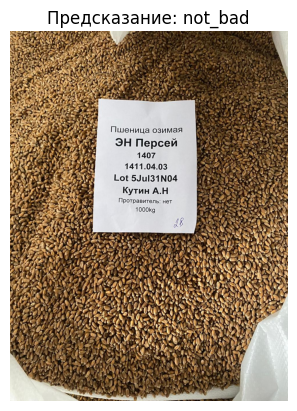

In [40]:
img_path = 'drive/MyDrive/Colab_Notebooks/data_split/test/good/photo_11.jpg'

img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

label, probs = predict_single_image_mil(best_model, img_path, ordered_classes)

print(f"Предсказанный класс: {label}")

plt.imshow(keras.preprocessing.image.load_img(img_path))
plt.title(f"Предсказание: {label}")
plt.axis('off')
plt.show()

In [41]:
att_model = keras.Model(inputs=model.input,
                        outputs=model.get_layer("att_softmax").output)

def visualize_attention(img, model, att_model, patch_size=(224,224), max_patches=10):
    patches = extract_patches(img, patch_size=patch_size, max_patches=max_patches)

    bag = preprocess_patch_bag(img, target_size=patch_size, max_patches=max_patches)
    bag = np.expand_dims(bag, axis=0)

    att_w = att_model.predict(bag, verbose=0)[0]
    att_w = att_w.squeeze()

    att_w = (att_w - att_w.min()) / (att_w.max() - att_w.min() + 1e-6)

    plt.figure(figsize=(10, 10))
    for i, patch in enumerate(patches):
        plt.subplot(int(np.ceil(len(patches)/3)), 3, i+1)
        plt.imshow(patch.astype("uint8"))
        plt.title(f"w={att_w[i]:.2f}")
        plt.axis("off")
    plt.show()


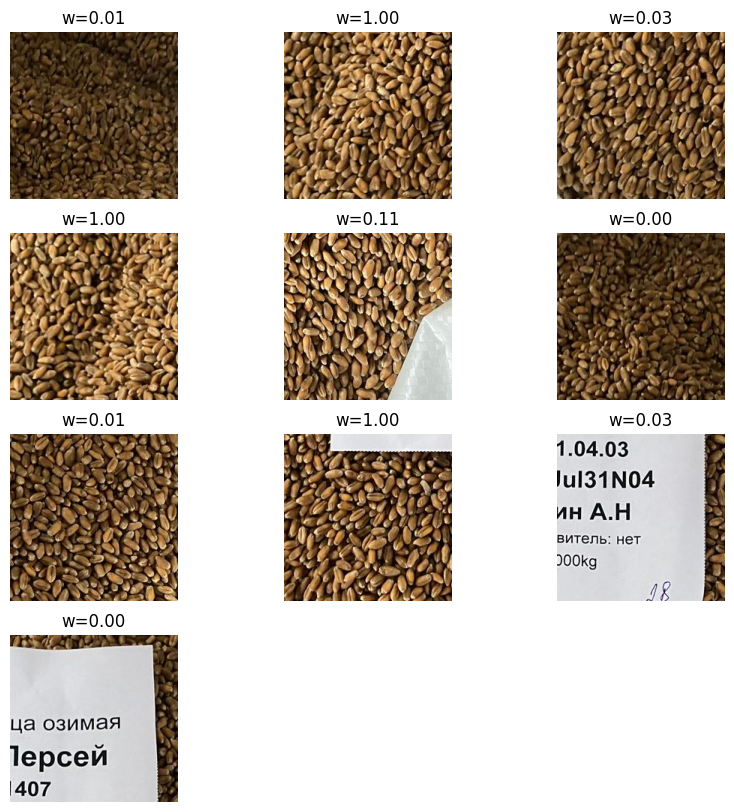

In [42]:
img_path = 'drive/MyDrive/Colab_Notebooks/data_split/test/good/photo_11.jpg'
♣
img = np.array(Image.open(img_path).convert("RGB"))

visualize_attention(img, model, att_model, max_patches=10)


## Конвертация модели в tflite

In [15]:
model_for_converting = keras.models.load_model("drive/MyDrive/Colab_Notebooks/best_model.keras",
                                            custom_objects={
                                                "att_pool_func": att_pool_func,
                                                "att_pool_shape": att_pool_shape,
                                                "ordinal_focal_loss": ordinal_focal_loss
                                            })

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_converting)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("drive/MyDrive/Colab_Notebooks/model.tflite", "wb") as  f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpjggkrchi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name='input_layer_30')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138159220802384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220803536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220803344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220802960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220804112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220803152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220804880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220804688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220803920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159220805456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159